In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tqdm
!pip install imbalanced-learn

In [ ]:
!pip install scikit-learn imbalanced-learn matplotlib

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold

import sys

from joblib import Parallel, delayed
import multiprocessing
import time

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from matplotlib.image import imread
import cv2

from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import random

import seaborn as sns

import matplotlib.pyplot as plt

from random import shuffle

from sklearn.utils import resample

In [ ]:
# FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION
# FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION
# FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION
# FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION
# FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION FEATURE EXTRACTION

def extract_raw(image_paths):
    start_time = time.time()
    features = []
    for path in image_paths:
        image = Image.open(path).convert('L')
        image = image.resize((64, 64))
        feature_vector = np.array(image).flatten()
        features.append(feature_vector)
    end_time = time.time()  # End timing here
    print(f"Feature extraction took {end_time - start_time:.2f} seconds for {len(image_paths)} images.")
    return np.array(features)

def extract_hog(image_paths):
    start_time = time.time()
    features = []
    for path in image_paths:
        image = imread(path, as_gray=True)
        image = resize(image, (64, 64)
        fd = hog(image, orientations=12, pixels_per_cell=(4, 4),
                 cells_per_block=(2, 2), block_norm='L2', visualize=False, channel_axis=None)
        features.append(fd)
    end_time = time.time()
    print(f"HOG Feature extraction took {end_time - start_time:.2f} seconds for {len(image_paths)} images.")
    return np.array(features)

def extract_lbp(image_paths, radius=3, n_points=24):
    start_time = time.time()
    features = []
    for path in image_paths:
        image = imread(path, as_gray=True)
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    print(f"LBP Feature extraction took {time.time() - start_time:.2f} seconds for {len(image_paths)} images.")
    return np.array(features)

def extract_intensity_histogram(image_paths, bins=256):
    start_time = time.time()
    features = []
    for path in image_paths:
        image = imread(path)
        hist = cv2.calcHist([image], [0], None, [bins], [0, 256])
        cv2.normalize(hist, hist)
        features.append(hist.flatten())
    end_time = time.time()
    print(f"Intensity Histogram Feature extraction took {end_time - start_time:.2f} second for {len(image_paths)} imagess.")
    return np.array(features)

In [ ]:
# Define the function to train and evaluate the SVM model
def train_svm(X_train, X_test, y_train, y_test, feature_name, use_class_weight=False, cv_folds=5):
    if use_class_weight:
        svm_pipeline = make_pipeline(StandardScaler(), SVC(class_weight='balanced'))
    else:
        svm_pipeline = make_pipeline(StandardScaler(), SVC())

    param_grid = {
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'svc__C': [1, 10, 20],
        'svc__gamma': ['scale', 'auto'],
        'svc__degree': [2, 3, 4, 5],
        'svc__coef0': [0, 0.1, 0.5]
    }

    start_time = time.time()
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    grid_search = GridSearchCV(svm_pipeline, param_grid, cv=kf, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)
    validation_time = time.time() - start_time

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    scoring = {'accuracy': 'accuracy', 'precision': 'precision_weighted', 'recall': 'recall_weighted', 'f1': 'f1_weighted'}
    cv_results = cross_validate(best_estimator, X_train, y_train, cv=kf, scoring=scoring)

    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_accuracy_std = cv_results['test_accuracy'].std()
    cv_precision_mean = cv_results['test_precision'].mean()
    cv_precision_std = cv_results['test_precision'].std()
    cv_recall_mean = cv_results['test_recall'].mean()
    cv_recall_std = cv_results['test_recall'].std()
    cv_f1_mean = cv_results['test_f1'].mean()
    cv_f1_std = cv_results['test_f1'].std()

    print(f"Feature extraction method: {feature_name}")
    print("Cross-validated Metrics:")
    print(f"Accuracy: {cv_accuracy_mean:.3f} ± {cv_accuracy_std:.3f}")
    print(f"Precision: {cv_precision_mean:.3f} ± {cv_precision_std:.3f}")
    print(f"Recall: {cv_recall_mean:.3f} ± {cv_recall_std:.3f}")
    print(f"F1 Score: {cv_f1_mean:.3f} ± {cv_f1_std:.3f}")
    print(f"Time spent on cross-validation and hyperparameter tuning: {validation_time:.2f} seconds")
    print(f"Best hyperparameters: {best_params}")
    print("")

    start_time = time.time()
    best_estimator.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = best_estimator.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    total_time = validation_time + training_time

    print(f"Spent time on training: {total_time:.2f} seconds")
    print("")
    print("Test Set Metrics:")
    print(f"Accuracy: {test_accuracy:.3f}, Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1 Score: {test_f1:.3f}")

    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=['False Positive', 'True Positive'],
                yticklabels=['False Negative', 'True Negative'])

    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

    return best_estimator

In [ ]:
normal_image_paths = glob.glob('.../path/...')
normal_mask_paths = glob.glob('.../path/...')
pneumonia_image_paths = glob.glob('.../path/...')
pneumonia_mask_paths = glob.glob('.../path/...')

image_paths = normal_image_paths + pneumonia_image_paths
mask_paths = normal_mask_paths + pneumonia_mask_paths
labels = [0] * len(normal_image_paths) + [1] * len(pneumonia_image_paths)


train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=42)

Number of Normal samples: 8153
Number of Pneumonia samples: 1076


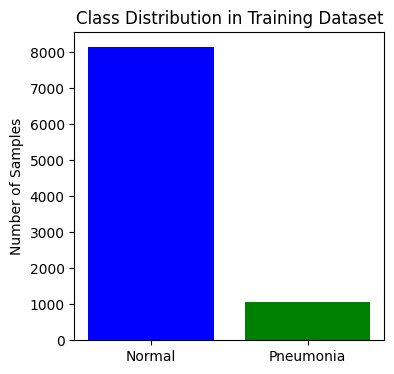

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

train_class_distribution = Counter(train_labels)

class_names = ['Normal', 'Pneumonia']
class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

print(f"Number of Normal samples: {class_counts[0]}")
print(f"Number of Pneumonia samples: {class_counts[1]}")

plt.figure(figsize=(4, 4))
plt.bar(class_names, class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.show()

Number of Normal samples after downsampling: 1076
Number of Pneumonia samples after downsampling: 1076


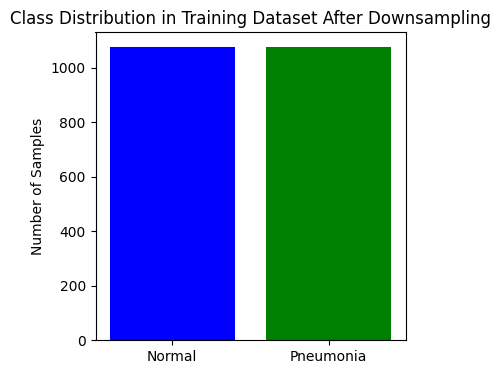

In [ ]:
# RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING
# RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING
# RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING
# RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING
# RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING RANDOM UNDERSAMPLING

image_paths = normal_image_paths + pneumonia_image_paths
labels = [0] * len(normal_image_paths) + [1] * len(pneumonia_image_paths)

X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

train_data = list(zip(X_train_paths, y_train))
majority_class = [x for x in train_data if x[1] == 0]
minority_class = [x for x in train_data if x[1] == 1]

majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),
                                random_state=42)

balanced_train_data = majority_downsampled + minority_class
shuffle(balanced_train_data)

X_train_paths_balanced, y_train_balanced = zip(*balanced_train_data)
X_train_paths_balanced = list(X_train_paths_balanced)
y_train_balanced = list(y_train_balanced)

train_class_distribution = Counter(y_train_balanced)
class_names = ['Normal', 'Pneumonia']
class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

print(f"Number of Normal samples after downsampling: {class_counts[0]}")
print(f"Number of Pneumonia samples after downsampling: {class_counts[1]}")

plt.figure(figsize=(4, 4))
plt.bar(class_names, class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset After Downsampling')
plt.show()

Number of Normal samples: 1076
Number of Pneumonia samples: 1076


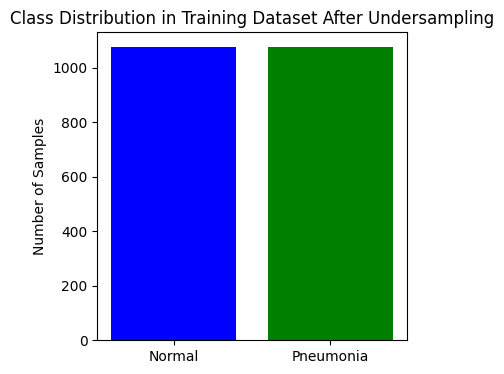

In [ ]:
train_class_distribution = Counter(y_train_balanced)

class_names = ['Normal', 'Pneumonia']
class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

print(f"Number of Normal samples: {class_counts[0]}")
print(f"Number of Pneumonia samples: {class_counts[1]}")

plt.figure(figsize=(4, 4))
plt.bar(class_names, class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset After Undersampling')
plt.show()

In [ ]:
zipped_train_data = list(zip(X_train_paths_balanced, y_train_balanced))

sampled_data = random.sample(zipped_train_data, 300)

sampled_image_paths, sampled_labels = zip(*sampled_data)

In [ ]:
# Extract features using RAW
features_train_raw = extract_raw(sampled_image_paths)
features_test_raw = extract_raw(X_test_paths)

In [ ]:
# Extract features using HOG
features_train_hog = extract_hog(X_train_paths_balanced)
features_test_hog = extract_hog(X_test_paths)

In [ ]:
# Extract features using LBP
features_train_lbp = extract_lbp(X_train_paths_balanced)
features_test_lbp = extract_lbp(X_test_paths)

In [ ]:
# Extract features using Intensity Histogram
features_train_hist = extract_intensity_histogram(X_train_paths_balanced)
features_test_hist = extract_intensity_histogram(X_test_paths)

In [ ]:
# Assuming you have sampled_image_paths and sampled_labels from the earlier sampling step
y_train_balanced = np.array(y_train_balanced)
y_test = np.array(y_test)

Evaluating SVM with Raw Pixel Features
Feature extraction method: Raw Pixel
Cross-validated Metrics:
Accuracy: 0.942 ± 0.031
Precision: 0.947 ± 0.026
Recall: 0.942 ± 0.031
F1 Score: 0.942 ± 0.030
Time spent on cross-validation and hyperparameter tuning: 76.05 seconds
Best hyperparameters: {'svc__C': 10, 'svc__coef0': 0.5, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

Spent time on training: 76.10 seconds

Test Set Metrics:
Accuracy: 0.967, Precision: 0.969, Recall: 0.967, F1 Score: 0.967


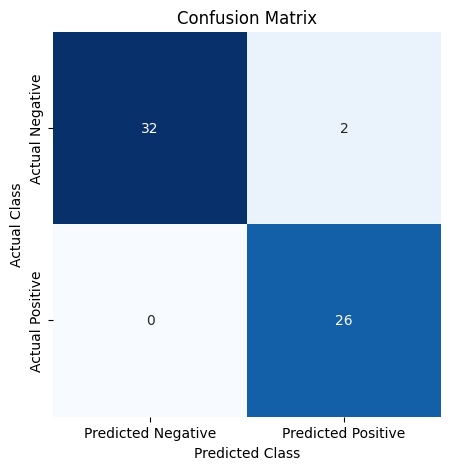

In [ ]:
print("Evaluating SVM with Raw Pixel Features")
svm_model_raw = train_svm(features_train_raw, features_test_raw, y_train_balanced, y_test, "Raw Pixel")

Evaluating SVM with HOG Features
Feature extraction method: Histogram of Oriented Gradients (HOG)
Cross-validated Metrics:
Accuracy: 0.933 ± 0.016
Precision: 0.938 ± 0.012
Recall: 0.933 ± 0.016
F1 Score: 0.934 ± 0.015
Time spent on cross-validation and hyperparameter tuning: 231.05 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Spent time on training: 231.39 seconds

Test Set Metrics:
Accuracy: 0.933, Precision: 0.936, Recall: 0.933, F1 Score: 0.934


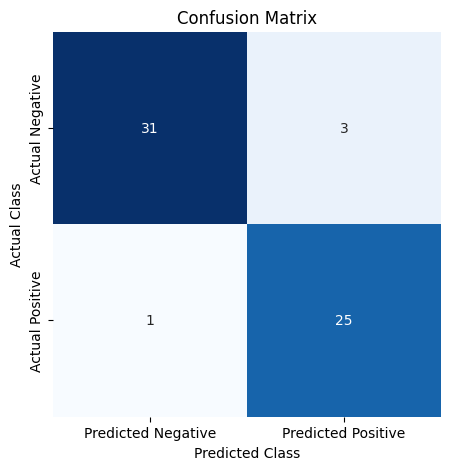

In [ ]:
print("Evaluating SVM with HOG Features")
svm_model_hog = train_svm(features_train_hog, features_test_hog, y_train_balanced, y_test, "Histogram of Oriented Gradients (HOG)")

Evaluating SVM with LBP Features
Feature extraction method: Local Binary Patterns (LBP)
Cross-validated Metrics:
Accuracy: 0.896 ± 0.013
Precision: 0.897 ± 0.013
Recall: 0.896 ± 0.013
F1 Score: 0.896 ± 0.013
Time spent on cross-validation and hyperparameter tuning: 5.62 seconds
Best hyperparameters: {'svc__C': 10, 'svc__coef0': 0.5, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

Spent time on training: 5.63 seconds

Test Set Metrics:
Accuracy: 0.867, Precision: 0.867, Recall: 0.867, F1 Score: 0.867


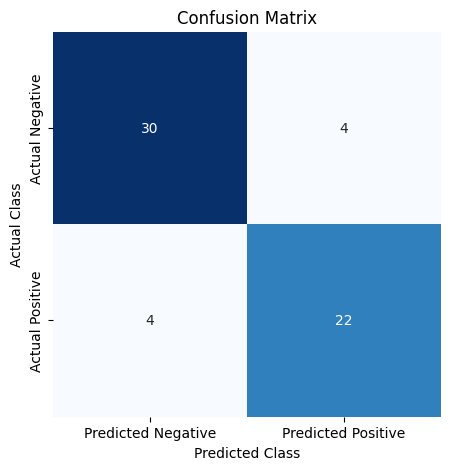

In [ ]:
print("Evaluating SVM with LBP Features")
svm_model_lbp = train_svm(features_train_lbp, features_test_lbp, y_train_balanced, y_test, "Local Binary Patterns (LBP)")

Evaluating SVM with Intensity Histogram Features
Feature extraction method: Intensity Histogram
Cross-validated Metrics:
Accuracy: 0.850 ± 0.055
Precision: 0.855 ± 0.054
Recall: 0.850 ± 0.055
F1 Score: 0.850 ± 0.053
Time spent on cross-validation and hyperparameter tuning: 7.26 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0.5, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

Spent time on training: 7.27 seconds

Test Set Metrics:
Accuracy: 0.850, Precision: 0.850, Recall: 0.850, F1 Score: 0.850


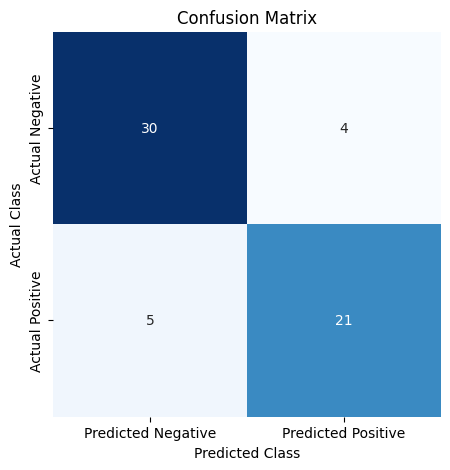

In [ ]:
print("Evaluating SVM with Intensity Histogram Features")
svm_model_intensity_hist = train_svm(features_train_hist, features_test_hist, y_train_balanced, y_test, "Intensity Histogram")

Number of samples in majority class (Normal) before resampling: 8153
Number of samples in minority class (Pneumonia) before resampling: 1076
Number of samples in upsampled minority class (Pneumonia): 8153
Number of Normal samples: 8153
Number of Pneumonia samples: 8153


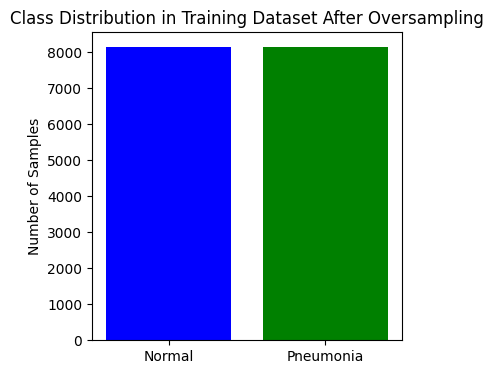

In [ ]:
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING
# RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING RANDOM OVERSAMPLING

X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

train_data = list(zip(X_train_paths, y_train))
majority_class = [x for x in train_data if x[1] == 0]
minority_class = [x for x in train_data if x[1] == 1]

print(f"Number of samples in majority class (Normal) before resampling: {len(majority_class)}")
print(f"Number of samples in minority class (Pneumonia) before resampling: {len(minority_class)}")

minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=42)

print(f"Number of samples in upsampled minority class (Pneumonia): {len(minority_upsampled)}")

balanced_train_data = majority_class + minority_upsampled

shuffle(balanced_train_data)

X_train_paths_balanced, y_train_balanced = zip(*balanced_train_data)
X_train_paths_balanced = list(X_train_paths_balanced)
y_train_balanced = list(y_train_balanced)

train_class_distribution = Counter(y_train_balanced)

class_names = ['Normal', 'Pneumonia']
class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

print(f"Number of Normal samples: {class_counts[0]}")
print(f"Number of Pneumonia samples: {class_counts[1]}")

plt.figure(figsize=(4, 4))
plt.bar(class_names, class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset After Oversampling')
plt.show()

In [ ]:
zipped_train_data = list(zip(X_train_paths_balanced, y_train_balanced))

sampled_data = random.sample(zipped_train_data, 300)

sampled_image_paths, sampled_labels = zip(*sampled_data)

In [ ]:
# Extract features using RAW
features_train_raw = extract_raw(X_train_paths_balanced)
features_test_raw = extract_raw(X_test_paths)

In [ ]:
# Extract features using HOG
features_train_hog = extract_hog(X_train_paths_balanced)
features_test_hog = extract_hog(X_test_paths)

In [ ]:
# Extract features using LBP
features_train_lbp = extract_lbp(X_train_paths_balanced)
features_test_lbp = extract_lbp(X_test_paths)

In [ ]:
# Extract features using Intensity Histogram
features_train_intensity_hist = extract_intensity_histogram(X_train_paths_balanced)
features_test_intensity_hist = extract_intensity_histogram(X_test_paths)

In [ ]:
# Labels
y_train_balanced = np.array(y_train_balanced)
y_test = np.array(y_test)

Oversampled Dataset - Evaluating SVM with Raw Pixel Features
Feature extraction method: Raw Pixel
Cross-validated Metrics:
Accuracy: 0.946 ± 0.017
Precision: 0.951 ± 0.014
Recall: 0.946 ± 0.017
F1 Score: 0.945 ± 0.017
Time spent on cross-validation and hyperparameter tuning: 37.09 seconds
Best hyperparameters: {'svc__C': 10, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Spent time on training: 37.19 seconds

Test Set Metrics:
Accuracy: 0.950, Precision: 0.954, Recall: 0.950, F1 Score: 0.950


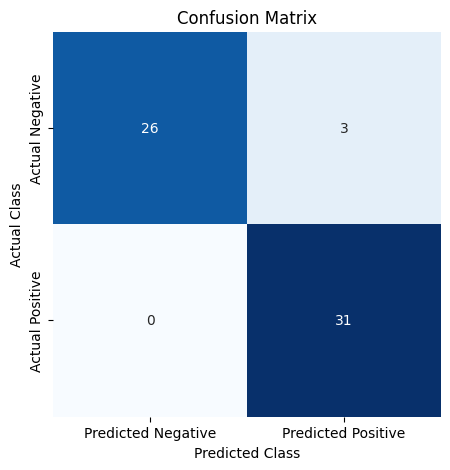

In [ ]:
print("Oversampled Dataset - Evaluating SVM with Raw Pixel Features")
svm_model_raw = train_svm(features_train_raw, features_test_raw, y_train_balanced, y_test, "Raw Pixel")

Oversampled Dataset - Evaluating SVM with HOG Features
Feature extraction method: Histogram of Oriented Gradients (HOG)
Cross-validated Metrics:
Accuracy: 0.938 ± 0.019
Precision: 0.941 ± 0.020
Recall: 0.938 ± 0.019
F1 Score: 0.937 ± 0.019
Time spent on cross-validation and hyperparameter tuning: 228.22 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Spent time on training: 228.54 seconds

Test Set Metrics:
Accuracy: 0.850, Precision: 0.869, Recall: 0.850, F1 Score: 0.847


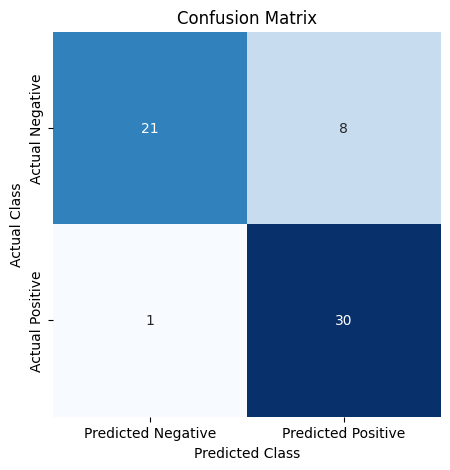

In [ ]:
print("Oversampled Dataset - Evaluating SVM with HOG Features")
svm_model_hog = train_svm(features_train_hog, features_test_hog, y_train_balanced, y_test, "Histogram of Oriented Gradients (HOG)")

Oversampled Dataset - Evaluating SVM with LBP Features
Feature extraction method: Local Binary Patterns (LBP)
Cross-validated Metrics:
Accuracy: 0.879 ± 0.024
Precision: 0.884 ± 0.028
Recall: 0.879 ± 0.024
F1 Score: 0.878 ± 0.024
Time spent on cross-validation and hyperparameter tuning: 3.83 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Spent time on training: 3.84 seconds

Test Set Metrics:
Accuracy: 0.867, Precision: 0.881, Recall: 0.867, F1 Score: 0.865


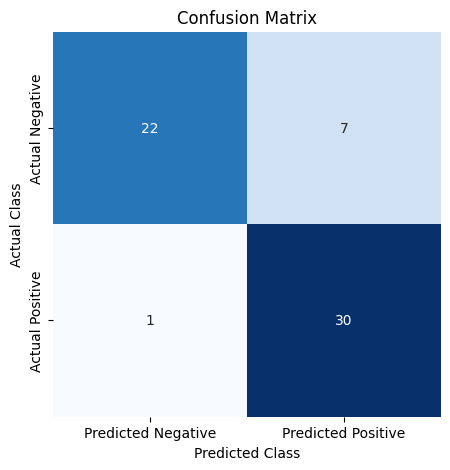

In [ ]:
print("Oversampled Dataset - Evaluating SVM with LBP Features")
svm_model_lbp = train_svm(features_train_lbp, features_test_lbp, y_train_balanced, y_test, "Local Binary Patterns (LBP)")

Oversampled Dataset - Evaluating SVM with Intensity Histogram Features
Feature extraction method: Intensity Histogram
Cross-validated Metrics:
Accuracy: 0.825 ± 0.069
Precision: 0.837 ± 0.072
Recall: 0.825 ± 0.069
F1 Score: 0.825 ± 0.069
Time spent on cross-validation and hyperparameter tuning: 9.72 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0.5, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

Spent time on training: 9.73 seconds

Test Set Metrics:
Accuracy: 0.783, Precision: 0.798, Recall: 0.783, F1 Score: 0.779


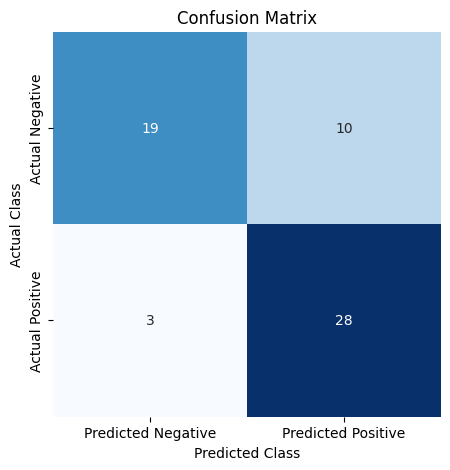

In [ ]:
print("Oversampled Dataset - Evaluating SVM with Intensity Histogram Features")
svm_model_intensity_hist = train_svm(features_train_intensity_hist, features_test_intensity_hist, y_train_balanced, y_test, "Intensity Histogram")

Number of selected images: 300
Class distribution: Counter({0: 265, 1: 35})
Training set class distribution: Counter({0: 212, 1: 28})
Test set class distribution: Counter({0: 53, 1: 7})


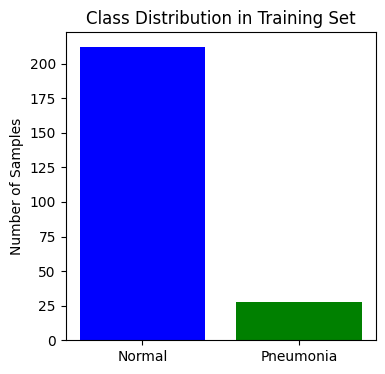

In [ ]:
# NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING
# NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING
# NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING
# NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING
# NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING NO SAMPLING - CLASS WEIGHTING

image_paths = normal_image_paths + pneumonia_image_paths
labels = [0] * len(normal_image_paths) + [1] * len(pneumonia_image_paths)
combined = list(zip(image_paths, labels))

subset_image_paths, _, subset_labels, _ = train_test_split(
    image_paths, labels, test_size=len(image_paths) - 300, stratify=labels, random_state=42)

subset = list(zip(subset_image_paths, subset_labels))
class_counts = Counter(subset_labels)
for label in class_counts.keys():
    if class_counts[label] < 2:
        needed_samples = 2 - class_counts[label]
        additional_samples = [item for item in combined if item[1] == label and item[0] not in subset_image_paths][:needed_samples]
        subset.extend(additional_samples)
        subset_image_paths, subset_labels = zip(*subset)

remaining_samples_needed = 300 - len(subset)
remaining_combined = [item for item in combined if item[0] not in subset_image_paths]
random.shuffle(remaining_combined)
subset.extend(remaining_combined[:remaining_samples_needed])

subset_image_paths, subset_labels = zip(*subset)
subset_image_paths = list(subset_image_paths)
subset_labels = list(subset_labels)

print(f"Number of selected images: {len(subset_image_paths)}")
print(f"Class distribution: {Counter(subset_labels)}")

X_train_paths_balanced, X_test_paths, y_train_balanced, y_test = train_test_split(subset_image_paths, subset_labels, test_size=0.2, random_state=42, stratify=subset_labels)

train_class_distribution = Counter(y_train_balanced)
test_class_distribution = Counter(y_test)

print(f"Training set class distribution: {train_class_distribution}")
print(f"Test set class distribution: {test_class_distribution}")

class_names = ['Normal', 'Pneumonia']
train_class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

plt.figure(figsize=(4, 4))
plt.bar(class_names, train_class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.show()

In [ ]:
# Extract features using RAW WITH NO SAMPLING
features_train_raw_balanced = extract_raw(X_train_paths_balanced)
features_test_raw = extract_raw(X_test_paths)

In [ ]:
# Extract features using HOG WITH NO SAMPLING
features_train_hog_balanced = extract_hog(X_train_paths_balanced)
features_test_hog = extract_hog(X_test_paths)

In [ ]:
# Extract features using LBP WITH NO SAMPLING
features_train_lbp_balanced = extract_lbp(X_train_paths_balanced)
features_test_lbp = extract_lbp(X_test_paths)

In [ ]:
# Extract features using Intensity Histogram WITH NO SAMPLING
features_train_intensity_histogram_balanced = extract_intensity_histogram(X_train_paths_balanced)
features_test_intensity_histogram = extract_intensity_histogram(X_test_paths)

In [ ]:
# Labels
y_train_balanced = np.array(y_train_balanced)
y_test = np.array(y_test)

No-sampled Dataset - Evaluating SVM with Raw Pixel Features
Feature extraction method: Raw Pixel
Cross-validated Metrics:
Accuracy: 0.967 ± 0.021
Precision: 0.967 ± 0.022
Recall: 0.967 ± 0.021
F1 Score: 0.963 ± 0.023
Time spent on cross-validation and hyperparameter tuning: 168.70 seconds
Best hyperparameters: {'svc__C': 10, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Spent time on training: 168.77 seconds

Test Set Metrics:
Accuracy: 0.983, Precision: 0.985, Recall: 0.983, F1 Score: 0.984


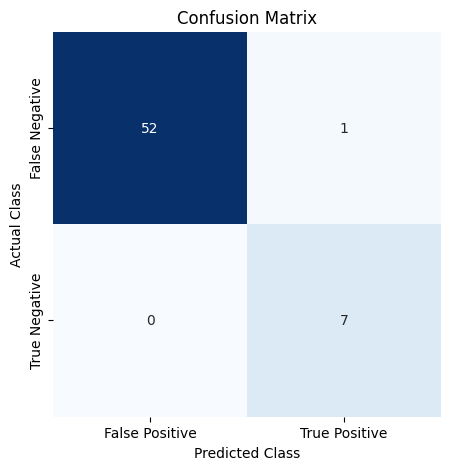

In [ ]:
print("No-sampled Dataset - Evaluating SVM with Raw Pixel Features")
svm_model_raw = train_svm(features_train_raw_balanced, features_test_raw, y_train_balanced, y_test, "Raw Pixel", use_class_weight=True)

No-sampled Dataset - Evaluating SVM with HOG Features
Feature extraction method: Histogram of Oriented Gradients (HOG)
Cross-validated Metrics:
Accuracy: 0.950 ± 0.021
Precision: 0.955 ± 0.018
Recall: 0.950 ± 0.021
F1 Score: 0.952 ± 0.020
Time spent on cross-validation and hyperparameter tuning: 846.06 seconds
Best hyperparameters: {'svc__C': 1, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}

Spent time on training: 846.45 seconds

Test Set Metrics:
Accuracy: 0.950, Precision: 0.965, Recall: 0.950, F1 Score: 0.954


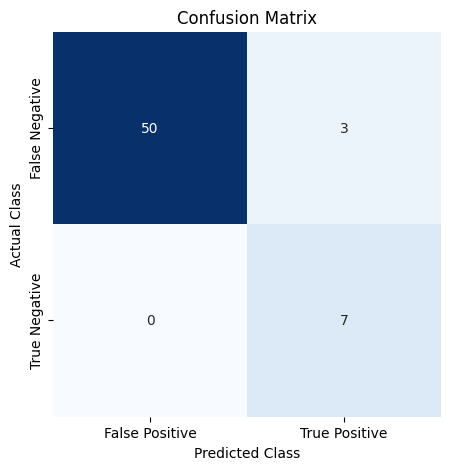

In [ ]:
print("No-sampled Dataset - Evaluating SVM with HOG Features")
svm_model_hog = train_svm(features_train_hog_balanced, features_test_hog, y_train_balanced, y_test, "Histogram of Oriented Gradients (HOG)", use_class_weight=True)

No-sampled Dataset  - Evaluating SVM with LBP Features
Feature extraction method: Local Binary Patterns (LBP)
Cross-validated Metrics:
Accuracy: 0.921 ± 0.055
Precision: 0.912 ± 0.063
Recall: 0.921 ± 0.055
F1 Score: 0.914 ± 0.060
Time spent on cross-validation and hyperparameter tuning: 13.25 seconds
Best hyperparameters: {'svc__C': 20, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Spent time on training: 13.26 seconds

Test Set Metrics:
Accuracy: 0.967, Precision: 0.967, Recall: 0.967, F1 Score: 0.967


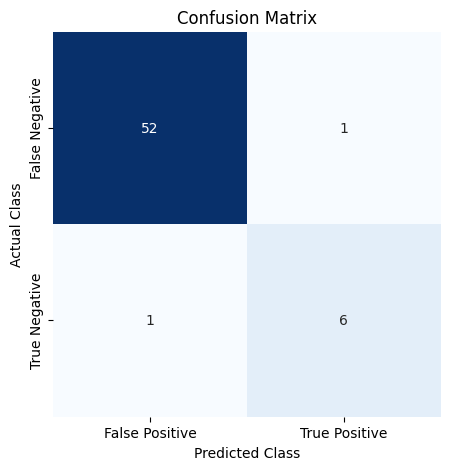

In [ ]:
print("No-sampled Dataset  - Evaluating SVM with LBP Features")
svm_model_lbp = train_svm(features_train_lbp_balanced, features_test_lbp, y_train_balanced, y_test, "Local Binary Patterns (LBP)", use_class_weight=True)

No-sampled Dataset - Evaluating SVM with Intensity Histogram Features
Feature extraction method: Intensity Histogram
Cross-validated Metrics:
Accuracy: 0.921 ± 0.048
Precision: 0.918 ± 0.051
Recall: 0.921 ± 0.048
F1 Score: 0.916 ± 0.052
Time spent on cross-validation and hyperparameter tuning: 17.93 seconds
Best hyperparameters: {'svc__C': 20, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Spent time on training: 17.95 seconds

Test Set Metrics:
Accuracy: 0.950, Precision: 0.948, Recall: 0.950, F1 Score: 0.948


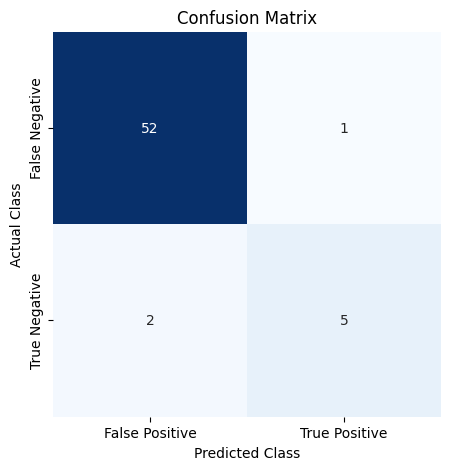

In [ ]:
print("No-sampled Dataset - Evaluating SVM with Intensity Histogram Features")
svm_model_intensity_hist = train_svm(features_train_intensity_hist_balanced, features_test_intensity_hist, y_train_balanced, y_test, "Intensity Histogram", use_class_weight=True)

Number of Normal samples in training set: 8153
Number of Pneumonia samples in training set: 1076


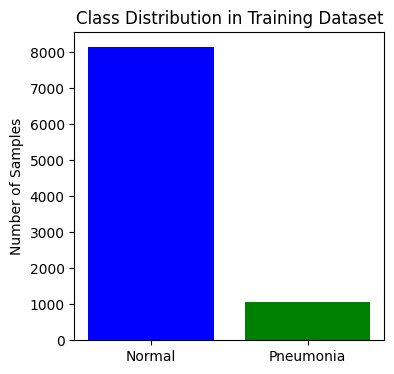

In [ ]:
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET
# TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET TRAIN ON THE WHOLE DATASET

image_paths = normal_image_paths + pneumonia_image_paths
labels = [0] * len(normal_image_paths) + [1] * len(pneumonia_image_paths)

X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

train_class_distribution = Counter(y_train)

class_names = ['Normal', 'Pneumonia']
class_counts = [train_class_distribution.get(0, 0), train_class_distribution.get(1, 0)]

print(f"Number of Normal samples in training set: {class_counts[0]}")
print(f"Number of Pneumonia samples in training set: {class_counts[1]}")

plt.figure(figsize=(4, 4))
plt.bar(class_names, class_counts, color=['blue', 'green'])
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.show()

In [ ]:
# Extract features from the training dataset
features_train_raw = extract_raw(X_train_paths)

Feature extraction took 4307.19 seconds for 9229 images.


In [ ]:
# Extract features from the test dataset
features_test_raw = extract_raw(X_test_paths)

Feature extraction took 1082.06 seconds for 2308 images.


In [ ]:
# Labels
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Run the SVM model on the entire dataset using Raw Pixel Features and class weighting
print("Running on the entire dataset - Evaluating SVM with Raw Pixel Features and Class Weighting")
svm_model_raw = train_svm(features_train_raw, features_test_raw, y_train, y_test, "Raw Pixel", use_class_weight=True)

Running on the entire dataset - Evaluating SVM with Raw Pixel Features and Class Weighting

Feature extraction method: Raw Pixel
Cross-validated Metrics:
Accuracy: 0.987 ± 0.005
Precision: 0.989 ± 0.005
Recall: 0.988 ± 0.005
F1 Score: 0.988 ± 0.005
Time spent on cross-validation and hyperparameter tuning: 5523.30 seconds
Best hyperparameters: {'svc__C': 10, 'svc__coef0': 0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Spent time on training: 6498.33 seconds

Test Set Metrics:
Accuracy: 0.991, Precision: 0.995, Recall: 0.991, F1 Score: 0.993
